# Control Ops Tutorial

In this tutorial we show how to use control flow operators in Caffe2 and give some details about their underlying implementations.

### Conditional Execution Using NetBuilder

Let's start with conditional operator. We will demonstrate how to use it in two Caffe2 APIs used for building nets: `NetBuilder` and `brew`.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from caffe2.python import workspace
from caffe2.python.core import Plan, to_execution_step, Net
from caffe2.python.net_builder import ops, NetBuilder

In the first example, we define several blobs and then use the 'If' operator to set the value of one of them conditionally depending on values of other blobs.

The pseudocode for the conditional examples we will implement is as follows:

    if (x > 0):
        y = 1
    else:
        y = 0

In [2]:
with NetBuilder() as nb:
    # Define our constants
    ops.Const(0.0, blob_out="zero")
    ops.Const(1.0, blob_out="one")
    ops.Const(0.5, blob_out="x")
    ops.Const(0.0, blob_out="y")
    # Define our conditional sequence
    with ops.IfNet(ops.GT(["x", "zero"])):
        ops.Copy("one", "y")
    with ops.Else():
        ops.Copy("zero", "y")

Note the usage of `NetBuilder`'s `ops.IfNet` and `ops.Else` calls: `ops.IfNet` accepts a blob reference or blob name as an input, it expects an input blob to have a scalar value convertible to bool. Note that the optional `ops.Else` is at the same level as `ops.IfNet` and immediately follows the corresponding `ops.IfNet`. Let's execute the resulting net (execution step) and check the values of the blobs.

Note that since x = 0.5, which is indeed greater than 0, we should expect y = 1 after execution.

In [3]:
# Initialize a Plan
plan = Plan('if_net_test')
# Add the NetBuilder definition above to the Plan
plan.AddStep(to_execution_step(nb))
# Initialize workspace for blobs
ws = workspace.C.Workspace()
# Run the Plan
ws.run(plan)
# Fetch some blobs and print
print('x = ', ws.blobs["x"].fetch())
print('y = ', ws.blobs["y"].fetch())

x =  0.5
y =  1.0


Before going further, it's important to understand the semantics of execution blocks ('then' and 'else' branches in the example above), i.e. handling of reads and writes into global (defined outside of the block) and local (defined inside the block) blobs.

`NetBuilder` uses the following set of rules:

 - In `NetBuilder`'s syntax, a blob's declaration and definition occur at the same time - we define an operator which writes its output into a blob with a given name.
 
 - `NetBuilder` keeps track of all operators seen before the current execution point in the same block and up the stack in parent blocks.
 
 - If an operator writes into a previously unseen blob, it creates a **local** blob that is visible only within the current block and the subsequent children blocks. Local blobs created in a given block are effectively deleted when we exit the block. Any write into previously defined (in the same block or in the parent blocks) blob updates an originally created blob and does not result in the redefinition of a blob.
 
 - An operator's input blobs have to be defined earlier in the same block or in the stack of parent blocks. 
 
 
As a result, in order to see the values computed by a block after its execution, the blobs of interest have to be defined outside of the block. This rule effectively forces visible blobs to always be correctly initialized.

To illustrate concepts of block semantics and provide a more sophisticated example, let's consider the following net:

In [4]:
with NetBuilder() as nb:
    # Define our constants
    ops.Const(0.0, blob_out="zero")
    ops.Const(1.0, blob_out="one")
    ops.Const(2.0, blob_out="two")
    ops.Const(1.5, blob_out="x")
    ops.Const(0.0, blob_out="y")
    # Define our conditional sequence
    with ops.IfNet(ops.GT(["x", "zero"])):
        ops.Copy("x", "local_blob")  # create local_blob using Copy -- this is not visible outside of this block
        with ops.IfNet(ops.LE(["local_blob", "one"])):
            ops.Copy("one", "y")
        with ops.Else():
            ops.Copy("two", "y")
    with ops.Else():
        ops.Copy("zero", "y")
        # Note that using local_blob would fail here because it is outside of the block in
        # which it was created

When we execute this, we expect that y == 2.0, and that `local_blob` will not exist in the workspace.

In [5]:
# Initialize a Plan
plan = Plan('if_net_test_2')
# Add the NetBuilder definition above to the Plan
plan.AddStep(to_execution_step(nb))
# Initialize workspace for blobs
ws = workspace.C.Workspace()
# Run the Plan
ws.run(plan)
# Fetch some blobs and print
print('x = ', ws.blobs["x"].fetch())
print('y = ', ws.blobs["y"].fetch())
# Assert that the local_blob does not exist in the workspace
# It should have been destroyed because of its locality
assert "local_blob" not in ws.blobs

x =  1.5
y =  2.0


### Conditional Execution Using Brew Module

Brew is another Caffe2 interface used to construct nets. Unlike `NetBuilder`, `brew` does not track the hierarchy of blocks and, as a result, we need to specify which blobs are considered local and which blobs are considered global when passing 'then' and 'else' models to an API call.

Let's start by importing the necessary items for the `brew` API.

In [6]:
from caffe2.python import brew
from caffe2.python.workspace import FeedBlob, RunNetOnce, FetchBlob
from caffe2.python.model_helper import ModelHelper

We will use the Caffe2's `ModelHelper` class to define and represent our models, as well as contain the parameter information about the models. Note that a `ModelHelper` object has two underlying nets:

    (1) param_init_net: Responsible for parameter initialization
    (2) net: Contains the main network definition, i.e. the graph of operators that the data flows through

Note that `ModelHelper` is similar to `NetBuilder` in that we define the operator graph first, and actually run later. With that said, let's define some models to act as conditional elements, and use the `brew` module to form the conditional statement that we want to run. We will construct the same statement used in the first example above.

In [7]:
# Initialize model, which will represent our main conditional model for this test
model = ModelHelper(name="test_if_model")

# Add variables and constants to our conditional model; notice how we add them to the param_init_net
model.param_init_net.ConstantFill([], ["zero"], shape=[1], value=0.0)
model.param_init_net.ConstantFill([], ["one"], shape=[1], value=1.0)
model.param_init_net.ConstantFill([], ["x"], shape=[1], value=0.5)
model.param_init_net.ConstantFill([], ["y"], shape=[1], value=0.0)

# Add Greater Than (GT) conditional operator to our model
#  which checks if "x" > "zero", and outputs the result in the "cond" blob
model.param_init_net.GT(["x", "zero"], "cond")

# Initialize a then_model, and add an operator which we will set to be
#  executed if the conditional model returns True
then_model = ModelHelper(name="then_test_model")
then_model.net.Copy("one", "y")

# Initialize an else_model, and add an operator which we will set to be
#  executed if the conditional model returns False
else_model = ModelHelper(name="else_test_model")
else_model.net.Copy("zero", "y")

# Use the brew module's handy cond operator to facilitate the construction of the operator graph
brew.cond(
    model=model,                               # main conditional model
    cond_blob="cond",                          # blob with condition value
    external_blobs=["x", "y", "zero", "one"],  # data blobs used in execution of conditional
    then_model=then_model,                     # pass then_model
    else_model=else_model)                     # pass else_model

Before we run the model, let's use Caffe2's graph visualization tool `net_drawer` to check if the operator graph makes sense.

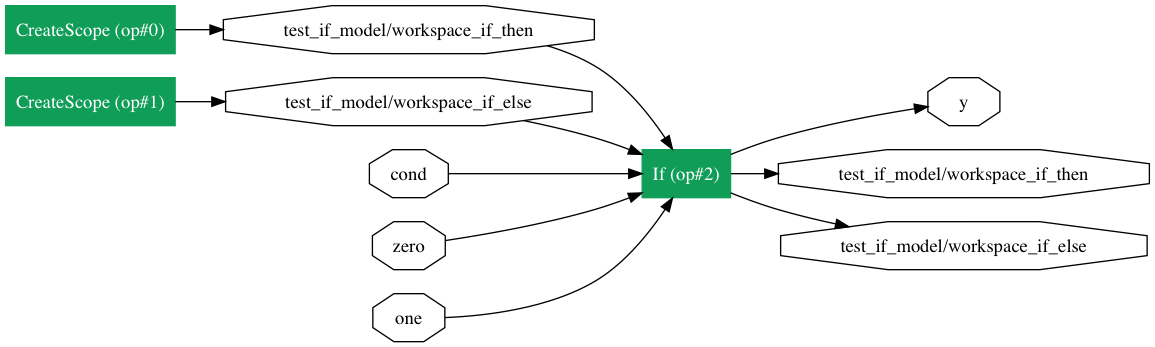

In [8]:
from caffe2.python import net_drawer
from IPython import display
graph = net_drawer.GetPydotGraph(model.net, rankdir="LR")
display.Image(graph.create_png(), width=800)

Now let's run the net! When using `ModelHelper`, we must first run the `param_init_net` to initialize paramaters, then we execute the main `net`.

In [9]:
# Run param_init_net once
RunNetOnce(model.param_init_net)
# Run main net (once in this case)
RunNetOnce(model.net)
# Fetch and examine some blobs
print("x = ", FetchBlob("x"))
print("y = ", FetchBlob("y"))

x =  [0.5]
y =  [1.]


### Loops Using NetBuilder

Another important control flow operator is 'While', which allows repeated execution of a fragment of net. Let's consider `NetBuilder`'s version first.

The pseudocode for this example is:

    i = 0
    y = 0
    while (i <= 7):
        y = i + y
        i += 1

In [10]:
with NetBuilder() as nb:
    # Define our variables
    ops.Const(0, blob_out="i")
    ops.Const(0, blob_out="y")
    
    # Define loop code and conditions
    with ops.WhileNet():
        with ops.Condition():
            ops.Add(["i", ops.Const(1)], ["i"])
            ops.LE(["i", ops.Const(7)])
        ops.Add(["i", "y"], ["y"])

As with the 'If' operator, standard block semantic rules apply. Note the usage of `ops.Condition` clause that should immediately follow `ops.WhileNet` and contains code that is executed before each iteration. The last operator in the condition clause is expected to have a single boolean output that determines whether the other iteration is executed.

In the example above we increment the counter ("i") before each iteration and accumulate its values in "y" blob, the loop's body is executed 7 times, the resulting blob values:

In [11]:
# Initialize a Plan
plan = Plan('while_net_test')
# Add the NetBuilder definition above to the Plan
plan.AddStep(to_execution_step(nb))
# Initialize workspace for blobs
ws = workspace.C.Workspace()
# Run the Plan
ws.run(plan)
# Fetch blobs and print
print("i = ", ws.blobs["i"].fetch())
print("y = ", ws.blobs["y"].fetch())

i =  8
y =  28


### Loops Using Brew Module

Now let's take a look at how to replicate the loop above using the `ModelHelper`+`brew` interface.

In [12]:
# Initialize model, which will represent our main conditional model for this test
model = ModelHelper(name="test_while_model")

# Add variables and constants to our model
model.param_init_net.ConstantFill([], ["i"], shape=[1], value=0)
model.param_init_net.ConstantFill([], ["one"], shape=[1], value=1)
model.param_init_net.ConstantFill([], ["seven"], shape=[1], value=7)
model.param_init_net.ConstantFill([], ["y"], shape=[1], value=0)

# Initialize a loop_model that represents the code to run inside of loop
loop_model = ModelHelper(name="loop_test_model")
loop_model.net.Add(["i", "y"], ["y"])

# Initialize cond_model that represents the conditional test that the loop
#  abides by, as well as the incrementation step
cond_model = ModelHelper(name="cond_test_model")
cond_model.net.Add(["i", "one"], "i")
cond_model.net.LE(["i", "seven"], "cond")

# Use brew's loop operator to facilitate the creation of the loop's operator graph
brew.loop(
    model=model,             # main model that contains data
    cond_blob="cond",        # explicitly specifying condition blob
    external_blobs=["cond", "i", "one", "seven", "y"], # data blobs used in execution of the loop
    loop_model=loop_model,   # pass loop_model
    cond_model=cond_model    # pass condition model (optional)
)

Once again, let's visualize the net using the `net_drawer`.

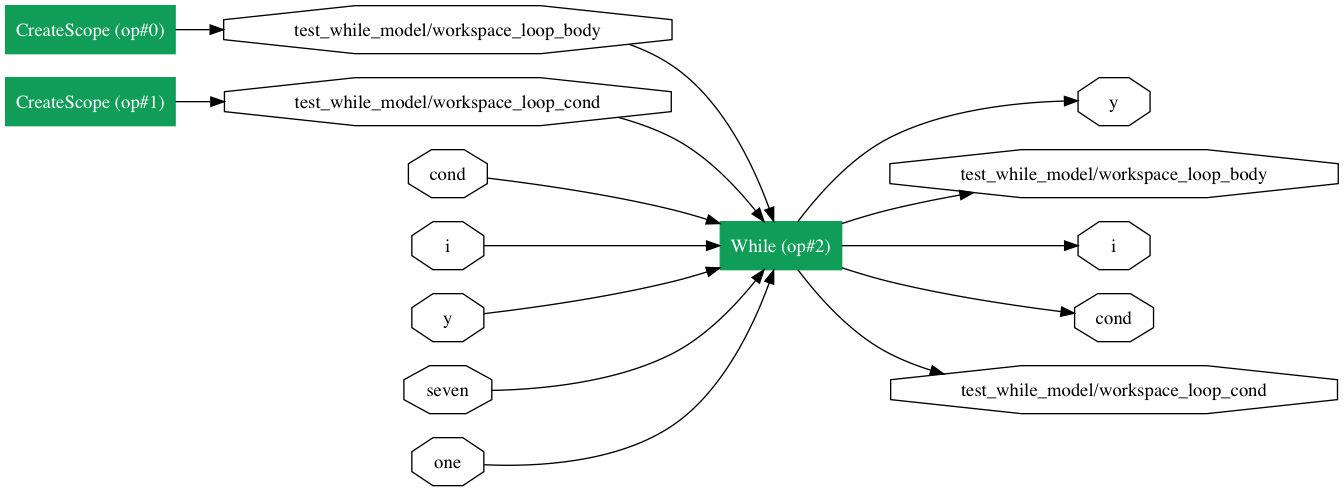

In [13]:
graph = net_drawer.GetPydotGraph(model.net, rankdir="LR")
display.Image(graph.create_png(), width=800)

Finally, we'll run the `param_init_net` and `net` and print our final blob values.

In [14]:
RunNetOnce(model.param_init_net)
RunNetOnce(model.net)
print("i = ", FetchBlob("i"))
print("y = ", FetchBlob("y"))

i =  [8]
y =  [28]


### Backpropagation

Both 'If' and 'While' operators support backpropagation. To illustrate how backpropagation with control ops work, let's consider the following examples in which we construct the operator graph using `NetBuilder` and obtain calculate gradients using the `AddGradientOperators` function. The first example shows the following conditional statement:

    x = 1-D numpy float array
    y = 4
    z = 0
    if (x > 0):
        z = y^2
    else:
        z = y^3

In [15]:
import numpy as np

# Feed blob called x, which is simply a 1-D numpy array [0.5]
FeedBlob("x", np.array(0.5, dtype='float32'))

# _use_control_ops=True forces NetBuilder to output single net as a result
# x is external for NetBuilder, so we let nb know about it through initial_scope param
with NetBuilder(_use_control_ops=True, initial_scope=["x"]) as nb:
    ops.Const(0.0, blob_out="zero")
    ops.Const(1.0, blob_out="one")
    ops.Const(4.0, blob_out="y")
    ops.Const(0.0, blob_out="z")
    with ops.IfNet(ops.GT(["x", "zero"])):
        ops.Pow("y", "z", exponent=2.0)
    with ops.Else():
        ops.Pow("y", "z", exponent=3.0)

# we should get a single net as output
assert len(nb.get()) == 1, "Expected a single net produced"
net = nb.get()[0]

# add gradient operators for 'z' blob
grad_map = net.AddGradientOperators(["z"])

In this case

$$x = 0.5$$

$$z = y^2 = 4^2 = 16$$

We will fetch the blob `y_grad`, which was generated by the `AddGradientOperators` call above. This blob contains the gradient of blob z with respect to y. According to basic calculus:

$$y\_grad = \frac{\partial{z}}{\partial{y}}y^2 = 2y = 2(4) = 8$$

In [16]:
# Run the net
RunNetOnce(net)
# Fetch blobs and print
print("x = ", FetchBlob("x"))
print("y = ", FetchBlob("y"))
print("z = ", FetchBlob("z"))
print("y_grad = ", FetchBlob("y_grad"))

x =  0.5
y =  4.0
z =  16.0
y_grad =  8.0


Now, let's change value of blob "x" to -0.5 and rerun net:

In [17]:
# To re-run net with different input, simply feed new blob
FeedBlob("x", np.array(-0.5, dtype='float32'))
RunNetOnce(net)
print("x = ", FetchBlob("x"))
print("y = ", FetchBlob("y"))
print("z = ", FetchBlob("z"))
print("y_grad = ", FetchBlob("y_grad"))

x =  -0.5
y =  4.0
z =  64.0
y_grad =  48.0


The next and final example illustrates backpropagation on the following loop:

    x = 2
    y = 3
    z = 2
    i = 0
    while (i <= 2):
        x = x^2
        if (i < 2):
            y = y^2
        else:
            z = z^3
        i += 1
    s = x + y + z
    
Note that this code essentially computes the sum of x^4 (by squaring x twice), y^2, and z^3.

In [18]:
with NetBuilder(_use_control_ops=True) as nb:
    # Define variables and constants
    ops.Copy(ops.Const(0), "i")
    ops.Copy(ops.Const(1), "one")
    ops.Copy(ops.Const(2), "two")
    ops.Copy(ops.Const(2.0), "x")
    ops.Copy(ops.Const(3.0), "y")
    ops.Copy(ops.Const(2.0), "z")
    
    # Define loop statement
    # Computes x^4, y^2, z^3
    with ops.WhileNet():
        with ops.Condition():
            ops.Add(["i", "one"], "i")
            ops.LE(["i", "two"])
        ops.Pow("x", "x", exponent=2.0)
        with ops.IfNet(ops.LT(["i", "two"])):
            ops.Pow("y", "y", exponent=2.0)
        with ops.Else():
            ops.Pow("z", "z", exponent=3.0)
    
    # Sum s = x + y + z
    ops.Add(["x", "y"], "x_plus_y")
    ops.Add(["x_plus_y", "z"], "s")

assert len(nb.get()) == 1, "Expected a single net produced"
net = nb.get()[0]

# Add gradient operators to output blob 's'
grad_map = net.AddGradientOperators(["s"])

In [19]:
workspace.RunNetOnce(net)
print("x = ", FetchBlob("x"))
print("x_grad = ", FetchBlob("x_grad")) # derivative: 4x^3
print("y = ", FetchBlob("y"))
print("y_grad = ", FetchBlob("y_grad")) # derivative: 2y
print("z = ", FetchBlob("z"))
print("z_grad = ", FetchBlob("z_grad")) # derivative: 3z^2

x =  16.0
x_grad =  32.0
y =  9.0
y_grad =  6.0
z =  8.0
z_grad =  12.0


### Implementation Notes

On the low level, Caffe2 uses the following set of operators to implement forward and backward branching and loops:
- If - accepts *then_net* and *else_net* nets as arguments and executes one of them, depending on input condition blob value, nets are executed **in the same** workspace;
- While - repeats execution of *loop_net* net passed as argument, net is executed in the same workspace;
- Do - special operator that creates a separate inner workspace, sets up blob mappings between outer and inner workspaces, and runs a net in an inner workspace;
- CreateScope/HasScope - special operators that create and keep track of workspaces used by Do operator.

Higher level libraries that implement branching and looping (e.g. in `NetBuilder`, `brew`), use these operators to build control flow, e.g. for 'If':
 - do necessary sanity checks (e.g. determine which blobs are initialized and check that subnet does not read undefined blobs)
 - wrap 'then' and 'else' branches into Do
 - setup correct blob mappings by specifying which local names are mapped to outer blobs
 - prepare scope structure, used by Do operator

While 'If' and 'While' Caffe2 ops can be used directly without creating local block workspaces, we encourage users to use higher level Caffe2 interfaces that provide necessary correctness guarantees.

Backpropagation for 'While' in general is expensive memory-wise - we have to save local workspace for every iteration of a block, including global blobs visible to the block. It is recommended that users use `RecurrentNetwork` operator instead in production environments.